In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

### Define constants to be used later

In [4]:
last_day_of_data_dt = dt.date(2017,8,23)

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)

# reflect the tables
Base.classes.keys()

['measurement', 'station']

In [8]:
# We can view all of the classes that automap found
inspector = inspect(engine)
table_names = inspector.get_table_names()
for table in table_names:
    print(f"{table}")
    column_names = inspector.get_columns(table)
    for column in column_names:
        PK = "  -PK-" if column['primary_key'] == 1 else ""
        print(f"\t{column['name']} {column['type']} {PK}")
    print("-"*50)

measurement
	id INTEGER   -PK-
	station TEXT 
	date TEXT 
	prcp FLOAT 
	tobs FLOAT 
--------------------------------------------------
station
	id INTEGER   -PK-
	station TEXT 
	name TEXT 
	latitude FLOAT 
	longitude FLOAT 
	elevation FLOAT 
--------------------------------------------------


In [9]:
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [11]:
plt.style.available
import matplotlib.ticker as ticker
# Played with different styles, but in the end kept the fivethirtyeight as it was defined above

In [12]:
# Get the last day of data from the database
from datetime import datetime
last_day_of_data_dt = session.query(func.max(Measurement.date)).first()[0]
last_day_of_data_dt = datetime.strptime(last_day_of_data_dt, '%Y-%m-%d').date()
print(type(last_day_of_data_dt))

<class 'datetime.date'>


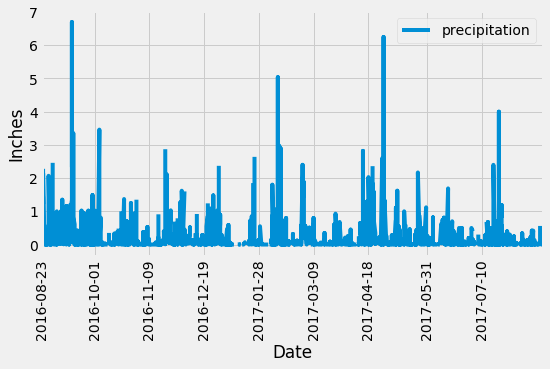

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
twelve_months_delta = relativedelta(months=12)
one_year_ago_date = last_day_of_data_dt - twelve_months_delta

# Perform a query to retrieve the data and precipitation scores
last_12_months = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year_ago_date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
last_12_months_df = pd.DataFrame(last_12_months, columns=['date', 'prcp'])
last_12_months_df.set_index("date", inplace=True)
last_12_months_df.index = pd.to_datetime(last_12_months_df.index)

# Sort the dataframe by date
last_12_months_df.sort_values("date", inplace=True)

xticks = []
min_date = last_12_months_df.index.min()
max_date = last_12_months_df.index.max()
min_tick_date = min_date
date_tick = min_tick_date

#HOW THE *#LDK WERE THESE XTICKS NATURALLY DETERMINED!!!!!!!
#I PROBABLY SHOULD HAVE JUST HARD CODED!!!!!!
days = 39
iterations = 0
max_comparison_date = max_date - dt.timedelta(days=days)
step = 1
while date_tick < max_comparison_date:
    xticks.append(date_tick)
    date_tick = date_tick + dt.timedelta(days=days)
    iterations += step
    if iterations == 2:
        days+=1
    if iterations == 6:
        days+=3
    if iterations == 7:
        days-=3
        

# Use Pandas Plotting with Matplotlib to plot the data
ax = last_12_months_df.plot(xlim=min_tick_date, xticks=xticks, rot=90,figsize=(8,5))
patches, labels = ax.get_legend_handles_labels()
labels[0] = "precipitation"
ax.set_xlabel("Date")
ax.set_ylabel("Inches")
ax.legend(patches, labels, loc='upper right')
ax.set_xlim(min_date, max_date)

#Cener the horizontal ticks
for tick in ax.xaxis.get_major_ticks():
    tick.tick1line.set_markersize(0)
    tick.tick2line.set_markersize(0)
    tick.label1.set_horizontalalignment('center')

plt.show()

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
last_12_months_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [15]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count(Station.id)).all()

[(9)]

In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
sel=[Station.station,
    func.count(Measurement.date)]
active_stations_query = session.query(*sel).filter(Measurement.station == Station.station).group_by(Station.station) \
        .order_by(func.count(Measurement.date).desc())
active_stations_query.all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
most_active_station = active_stations_query.limit(1)[0][0]
most_active_station
sel=[func.min(Measurement.tobs),
    func.max(Measurement.tobs),
    func.avg(Measurement.tobs)]

statistics = session.query(*sel).filter(Measurement.station == Station.station).filter(Station.station == most_active_station).all()
print(f"Statistics for most active station: {most_active_station}")
print(f"\tlowest temperature recorded : {statistics[0][0]}")
print(f"\thighest temperature recorded: {statistics[0][1]}")
print(f"\taverage temperature recorded: {round(statistics[0][2], 1)}")


Statistics for most active station: USC00519281
	lowest temperature recorded : 54.0
	highest temperature recorded: 85.0
	average temperature recorded: 71.7


USC00519281
352


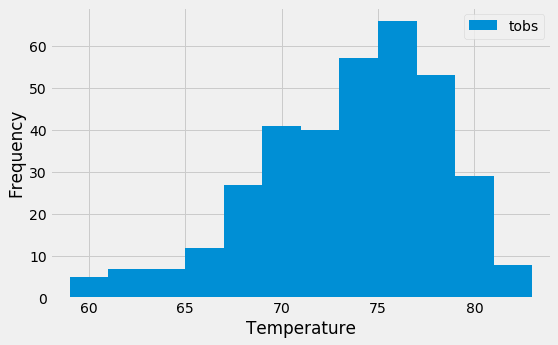

In [18]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
sel=[Station.station,
    func.count(Measurement.tobs)]


active_stations_query = session.query(*sel).filter(Measurement.station == Station.station) \
        .filter(Measurement.tobs != None) \
        .group_by(Station.station) \
        .order_by(func.count(Measurement.tobs).desc())
selected_station = active_stations_query.limit(1).all()[0][0]

#selected_station = most_active_station

print(selected_station)

last_12_months_temp = session.query(Measurement.tobs) \
        .filter(Measurement.date >= one_year_ago_date) \
        .filter(Measurement.station == selected_station) \
        .filter(Measurement.tobs != None).order_by(Measurement.tobs).all()
last_12_months_temp = list(np.ravel(last_12_months_temp))

#print(last_12_months_temp)

temperatures = []
for temperature in last_12_months_temp:
    temperatures.append(temperature)

min_temp = min(temperatures)
max_temp = max(temperatures)

print(len(temperatures))

fig = plt.figure(figsize=(8,5))
#ax = fig.add_axes([0.1, 0.1, 0.6, 0.75])
ax = plt.hist(temperatures, bins=12)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.xlim(min_temp -1, max_temp + 1)

plt.legend(("tobs",), loc="best")

## Bonus Challenge Assignment

In [19]:
import scipy.stats as stats
from scipy.stats import ttest_ind, ttest_ind_from_stats


In [20]:
#temperature Analysis I
# The date is a test....
# Use the like where the month is june
june_temperatures = session.query(Measurement.tobs).filter(Measurement.date.ilike('____-06-__')).all()
december_temperatures = session.query(Measurement.tobs).filter(Measurement.date.ilike('____-12-__')).all()
june_temperatures = list(np.ravel(june_temperatures))
december_temperatures = list(np.ravel(december_temperatures))

june_df = pd.DataFrame(june_temperatures)
december_df = pd.DataFrame(december_temperatures)

t, p = ttest_ind(june_temperatures, december_temperatures, equal_var=False)
print(f"ttest_ind:      t = {t}  p = {p}")

# Compute the descriptive statistics of june and december data.
#referenced from https://stackoverflow.com/questions/22611446/perform-2-sample-t-test
june_bar = june_df.mean()
june_var = june_df.var(ddof=1)
njune = june_df.size
june_dof = njune - 1

december_bar = december_df.mean()
december_var = december_df.var(ddof=1)
ndecember = december_df.size
december_dof = ndecember - 1

#std deviation
s = np.sqrt((june_var + december_var)/2)
print(f"std deviation={s}")

## Calculate the t-statistics
t = (june_bar - december_bar)/(s*np.sqrt(2/njune))
print(f"t-statistics = {t}")

t2, p2 = ttest_ind_from_stats(june_bar, np.sqrt(june_var), njune,
                              december_bar, np.sqrt(december_var), ndecember,
                              equal_var=False)
print("ttest_ind_from_stats: t = %g  p = %g" % (t2, p2))



ttest_ind:      t = 31.355036920962423  p = 4.193529835915755e-187
std deviation=0    3.510177
dtype: float64
t-statistics = 0    32.414044
dtype: float64
ttest_ind_from_stats: t = 31.355  p = 4.19353e-187


#### Bonus:  Temperature Analysis I

A t value greater than 2.8 indicates a difference, and with the value above 31 they are very different.  With the p Value significantly below .05, we can have strong faith in the difference.  I did not use paired t-test because of different different number of items in the sample.

In [21]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [22]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_dates = [dt.date(2018,6,1), dt.date(2018,6,2), dt.date(2018,6,3), dt.date(2018,6,4), 
              dt.date(2018,6, 5), dt.date(2018,6,6), dt.date(2018,6,7)]
last_year_dates = [dt - twelve_months_delta for dt in trip_dates]
min_last_year_date = min(last_year_dates)
max_last_year_date = max(last_year_dates)

vacation_temp_stats = calc_temps(min_last_year_date, max_last_year_date)
print(f"For vacation starting {trip_dates[0]} and ending {trip_dates[-1]} last year statistics are:")
min_temp, avg_temp, max_temp = np.ravel(vacation_temp_stats)
print(f"Min Temp={min_temp}, Avg Temp={round(avg_temp, 1)}, Max Temp={max_temp}")

For vacation starting 2018-06-01 and ending 2018-06-07 last year statistics are:
Min Temp=74.0, Avg Temp=77.8, Max Temp=81.0


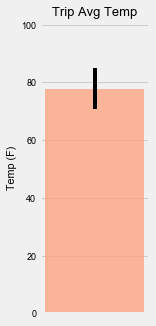

In [23]:
font = {'family' : 'arial',
        'weight' : 'ultralight',
        'size'   : 9}
plt.rc('font', **font)

# to remove the vertical lines
# https://stackoverflow.com/questions/16074392/getting-vertical-gridlines-to-appear-in-line-plot-in-matplotlib
fig, ax = plt.subplots(figsize=(1.75, 5))
ax.xaxis.grid(False)

# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

plt.bar(min_temp, height=avg_temp, color="lightsalmon", alpha=0.75, yerr=(max_temp - min_temp))
plt.ylim(0, 101)
plt.title("Trip Avg Temp")
plt.ylabel("Temp (F)")

#to remove the bottom xticks
#https://stackoverflow.com/questions/12998430/remove-xticks-in-a-matplotlib-plot
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.show()

In [24]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
sel = (Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp))
total_rainfall_per_station = session.query(*sel).filter(Station.station == Measurement.station) \
                                .group_by(Station.station) \
                                .order_by(func.sum(Measurement.prcp).desc()).all()
total_rainfall_per_station

[('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  1068.0899999999997),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  588.6400000000001),
 ('USC00513117',
  'KANEOHE 838.1, HI US',
  21.4234,
  -157.8015,
  14.6,
  382.6199999999998),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  295.6800000000001),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  234.49000000000007),
 ('USC00519397',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  131.61999999999992),
 ('USC00511918',
  'HONOLULU OBSERVATORY 702.2, HI US',
  21.3152,
  -157.9992,
  0.9,
  92.67999999999995),
 ('USC00518838',
  'UPPER WAHIAWA 874.3, HI US',
  21.4992,
  -158.0111,
  306.6,
  70.86999999999999),
 ('USC00517948',
  'PEARL CITY, HI US',
  21.3934,
  -157.9751,
  11.9,
  43.43999999999998)]

In [25]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [26]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
normals = []

# Set the start and end date of the trip
start_date = min(trip_dates)
end_date = max(trip_dates)
#start_date = f"{str(trip_dates[0].month).zfill(2)}-{str(trip_dates[0].day).zfill(2)}"
#end_date =  f"{str(trip_dates[-1].month).zfill(2)}-{str(trip_dates[-1].day).zfill(2)}"

# Use the start and end date to create a range of dates
number_of_vacation_days = (end_date - start_date).days + 1
date_list = [start_date + relativedelta(days=x) for x in range(0, number_of_vacation_days)]

# Stip off the year and save a list of %m-%d strings
stripped_date_list = [f"{str(dt.month).zfill(2)}-{str(dt.day).zfill(2)}" for dt in date_list]

# Loop through the list of %m-%d strings and calculate the normals for each date
for stripped_dt in stripped_date_list:
    normals.append(np.ravel(daily_normals(stripped_dt)))

normals

[array([64.        , 74.61403509, 81.        ]),
 array([65. , 74.4, 81. ]),
 array([65.        , 74.03448276, 80.        ]),
 array([65.        , 73.81818182, 81.        ]),
 array([68.        , 74.85454545, 81.        ]),
 array([70.       , 75.1754386, 80.       ]),
 array([68.        , 75.07142857, 81.        ])]

In [27]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_days_df = pd.DataFrame(normals, columns=['tmin', 'tavg', 'tmax'])
trip_days_df['trip_dates'] = trip_dates
trip_days_df.set_index('trip_dates', inplace=True)
trip_days_df

,tmin,tavg,tmax
trip_dates,,,
2018-06-01,64.0,74.614035,81.0
2018-06-02,65.0,74.400000,81.0
2018-06-03,65.0,74.034483,80.0
2018-06-04,65.0,73.818182,81.0
2018-06-05,68.0,74.854545,81.0
2018-06-06,70.0,75.175439,80.0
2018-06-07,68.0,75.071429,81.0


Major ticks of y axis
off off True
off off True
off off True
off off True
off off True
Major ticks of x axis
off off True
off off True
off off True
off off True
off off True
off off True
off off True


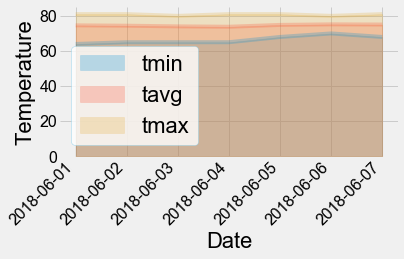

In [29]:
# Plot the daily normals as an area plot with `stacked=False`
plt.rc('font', **font)

y_ticks = [0, 20, 40, 60, 80]
ax = trip_days_df.plot.area(stacked=False, rot=45, alpha=.25, clip_on=True)
ax.set_ylabel("Temperature", fontsize=22)
ax.set_xlabel("Date", fontsize=22)
ax.set_yticks(y_ticks)

#ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.tight_layout()
for tick in ax.xaxis.get_major_ticks():
    tick.tick1line.set_markersize(0)
    tick.tick2line.set_markersize(0)
    tick.label.set_fontsize(16) 
    tick.label1.set_horizontalalignment('right')
for tick in ax.yaxis.get_major_ticks():
    tick.tick1line.set_markersize(0)
    tick.tick2line.set_markersize(0)
    tick.label.set_fontsize(16) 

ax.legend(loc='best', prop={'size': 20})

from matplotlib.font_manager import FontProperties
fontP = FontProperties(weight=550)
fontP.set_size(20)


#ax.legend(loc='best', ncol=1, bbox_to_anchor=(0, 0, 1, 1),
#           prop = fontP, facecolor='white', edgecolor='skyblue')
legend = plt.legend(frameon = 1, fontsize=22)
#legend.prop(fontP)
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('skyblue')
plt.rcParams.update({'font.size': 20})
ax.tick_params(axis='y',length=0)

ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

#Trying to turn off ticks
ax.tick_params(
    axis='both',  
    which='both',      

    bottom='off',     
    top='off',         
    left='off',
    right='off',

    pad=3) 
print( "Major ticks of y axis"  )                                            
for tick in ax.yaxis.get_major_ticks():
    #tick.gridline.set_visible(False)
    print( tick.tick1line.get_visible(), tick.tick2line.get_visible(), tick.gridline.get_visible()  )
print( "Major ticks of x axis"  )                                            
for tick in ax.xaxis.get_major_ticks():
    #tick.gridline.set_visible(true)
    print( tick.tick1line.get_visible(), tick.tick2line.get_visible(), tick.gridline.get_visible()  )   
plt.show()